# 1. Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score                         
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

from matplotlib import pyplot
import seaborn as sns

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from IPython.display import FileLink

import shap

#CONSTS
CATEGORICAL_FEATURES = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]
BATCH_SIZE = 1_000_000
VARIANCE_THRESHOLD = 0.03
NULL_VALUES_THRESHOLD = 0.95

# 2. Helper Code

In [2]:
#function for getting best indexes for batches, so we won't split the information of the same customer_ID
#we are processing the data in batches due memory constraints 
def get_indexes_for_batching(df):
    indexes = []
    size = df.shape[0]
    for i in range(BATCH_SIZE, size, BATCH_SIZE):
        temp = currCustomer = df['customer_ID'][i]
        index = i
        while temp == currCustomer:
            index += 1
            temp = df['customer_ID'][index]
        indexes.append(index)
    if indexes[-1] != size - 1: 
        indexes.append(size - 1)
    
    return indexes

In [3]:
#function that combines customer entries to one entry based on median of each colmun
def combine_customer_entries(df, indexes, criteria, clean_rows=False):
    prev_index = 0
    train_data_features = pd.DataFrame()
    for i, curr_index in enumerate(indexes):
        if (criteria == 'mean'):
            cur_df = df.iloc[prev_index:curr_index,:].groupby(['customer_ID']).mean()
        elif (criteria == 'median'):
            cur_df = df.iloc[prev_index:curr_index,:].groupby(['customer_ID']).median()
        else:
            print("Error, must choose mean or median")
            return
        if (clean_rows):
            cur_df = cur_df.dropna(how='all')
        train_data_features = train_data_features.append(cur_df)
        prev_index = curr_index
        print(i, train_data_features.shape)
    return train_data_features

In [4]:
#function that keeps only the colmuns above variance threshold 
def apply_variance_threshold(df):
    selector = VarianceThreshold(VARIANCE_THRESHOLD)
    selector.fit(df)
    return selector.get_support(indices=True)

# 3. Loading the data

In [5]:
#load train data
train_data = pd.read_parquet('../input/amex-parquet/train_data.parquet')
print("The shape with the categorical features is:", train_data.shape)

#get train labels
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv').iloc[:,1]
print("The shape of the train labels is:", train_labels.shape)

The shape with the categorical features is: (5531451, 191)
The shape of the train labels is: (458913,)


In [6]:
#remove catagorical features & target colmun
train_data = train_data.drop(CATEGORICAL_FEATURES, axis=1)
train_data = train_data.drop('target', axis=1)
print("The shape without the categorical features is:", train_data.shape)
train_data.head()

The shape without the categorical features is: (5531451, 179)


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827


In [7]:
#remove colmuns that have more then THRESHOLD precent of missing values
print(train_data.shape)
train_data = train_data.dropna(axis=1, thresh=int(NULL_VALUES_THRESHOLD*train_data.shape[0]))
print(train_data.shape)

(5531451, 179)
(5531451, 140)


In [8]:
#get indexes for processing batches of data
indexes_for_batching = get_indexes_for_batching(train_data)
print(indexes_for_batching)

[1000012, 2000003, 3000003, 4000002, 5000008, 5531450]


# 4. Preprocessing the data

In [9]:
#creates the features vector for each 'customer_ID' according to criteria (mean or median)
#splits the dataset to train set and test set
def preprocessing_and_split_data(df_train_data, df_train_labels, indexes_for_batching, criteria):
    #get combined entries for each customer based on median of each clomun 
    data_features = combine_customer_entries(df_train_data, indexes_for_batching, criteria)
    
    #setting train and test from training data received from processing
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(data_features, df_train_labels, test_size=0.1, random_state=26)
    
    #get only data with colmuns with variance above threshold
    #the colmuns to keep are determined only by train set 
    columns_to_keep = apply_variance_threshold(x_train_split)
    x_train_split_final = x_train_split[x_train_split.columns[columns_to_keep]]
    x_test_split_final = x_test_split[x_test_split.columns[columns_to_keep]]
    
    return columns_to_keep, x_train_split_final, x_test_split_final, y_train_split, y_test_split

In [10]:
#creating the median features
columns_to_keep_median, x_train_median, x_test_median, y_train_median, y_test_median \
= preprocessing_and_split_data(train_data, train_labels, indexes_for_batching, 'median')
print("The median features shape:", x_train_median.shape)

0 (82975, 138)
1 (165819, 138)
2 (248849, 138)
3 (331853, 138)
4 (414808, 138)
5 (458913, 138)
The median features shape: (413021, 93)


In [11]:
#creating the mean features
columns_to_keep_mean, x_train_mean, x_test_mean, y_train_mean, y_test_mean \
= preprocessing_and_split_data(train_data, train_labels, indexes_for_batching, 'mean')
print("The mean features shape:", x_train_mean.shape)
print("The chosen columns:", x_train_mean.columns)
x_train_mean.head()

0 (82975, 138)
1 (165819, 138)
2 (248849, 138)
3 (331853, 138)
4 (414808, 138)
5 (458913, 138)
The mean features shape: (413021, 93)
The chosen columns: Index(['P_2', 'B_1', 'B_2', 'B_3', 'D_44', 'B_4', 'D_45', 'B_5', 'D_47', 'B_6',
       'B_7', 'B_8', 'D_51', 'B_9', 'R_3', 'B_10', 'S_5', 'B_11', 'S_6',
       'B_12', 'S_8', 'D_55', 'B_13', 'D_58', 'B_14', 'D_59', 'D_60', 'B_15',
       'D_65', 'B_16', 'B_18', 'B_19', 'B_20', 'R_6', 'S_13', 'B_21', 'D_69',
       'B_22', 'D_70', 'D_71', 'D_72', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24',
       'R_7', 'B_25', 'B_26', 'D_78', 'D_79', 'S_16', 'D_80', 'R_10', 'D_81',
       'B_28', 'D_83', 'R_14', 'D_84', 'R_20', 'B_33', 'D_92', 'S_22', 'S_23',
       'S_24', 'S_26', 'D_102', 'D_103', 'D_104', 'D_107', 'B_37', 'R_27',
       'D_112', 'B_40', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122',
       'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'B_41', 'D_130',
       'D_131', 'D_139', 'D_141', 'D_143', 'D_145'],
      dtype='object

,P_2,B_1,B_2,B_3,D_44,B_4,D_45,B_5,D_47,B_6,...,D_127,D_128,D_129,B_41,D_130,D_131,D_139,D_141,D_143,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
9a3006b4c7305e4068ac1e887c7825cffc92ef56a4825e6ea48f493196efe328,0.744920,0.042318,0.507038,0.004948,0.005735,0.035569,0.008546,0.060970,0.319516,0.465602,...,0.004537,1.005193,0.008477,0.004163,0.002999,0.003436,0.006277,0.007374,0.006532,0.006302
0f02b103ab7c2b3726cac1c1a29014cc94105cac34bc8285b1854455209b131b,0.794052,0.016332,0.830824,0.003018,0.004547,0.063299,0.175595,0.025863,0.772988,0.198053,...,0.004965,0.005285,0.004759,0.005775,0.004848,0.004355,0.005328,0.003876,0.006597,0.004806
e75467ccaf4b04e09e7aa701c4a9866a3d6605e5a95e2d715f2f8fe63254f9cc,0.864360,0.029108,0.962228,0.006648,0.003855,0.004557,0.102165,0.026862,0.305777,1.221978,...,0.005183,0.005155,0.003549,0.005927,0.005689,0.004942,0.005933,0.005831,0.004895,0.005178
e79c9f46a56e0f04d256a9601a96da58c3944cc21fe1e554034effb9517c4399,0.844211,0.032196,1.006546,0.007019,0.007112,0.051921,0.254514,0.111199,0.844991,0.167898,...,0.006578,0.005270,0.004741,0.006253,0.004304,0.005079,0.005264,0.005230,0.003982,0.006155
3a7380a724a21a1e2b5ee8da2e2dcc5c94ef6c7f0eced697bc67c6986334b9f1,0.240001,0.321626,0.034030,0.292809,0.102385,0.098797,0.024338,0.008385,0.020078,0.022904,...,0.005210,0.006709,0.005443,0.005399,0.004460,0.005625,0.004583,0.003973,0.004137,0.005392


# 5. Training

In [12]:
#set up lgbm model, train on train part in training data and test vs test part in training data!
def train_and_eval_model(model, model_name, x_train, x_test, y_train, y_test, criteria, is_silent=False):
    start = time.time()
    if (is_silent):
        model.fit(x_train, y_train, silent=is_silent) #for canceling the training prints
    else:
        model.fit(x_train, y_train)
    end = time.time()
    print("The training took", '{:.2f}'.format(end - start) ,"seconds")
    
    y_predict_train=model.predict(x_train)
    y_predict_test=model.predict(x_test)
    
    print('Results with the {} features:'.format(criteria))
    print('Classifier Accuracy on the train set: {:.3f}'.format(accuracy_score(y_train, y_predict_train)))
    print('Classifier Accuracy on the test set: {:.3f}'.format(accuracy_score(y_test, y_predict_test)))
    print('Classifier Recall on the test set: {:.3f}'.format(recall_score(y_test, y_predict_test)))
    print('Classifier Precision on the test set: {:.3f}'.format(precision_score(y_test, y_predict_test)))
    
    # Create a DataFrame from our training statistics
    training_stats = []
    training_stats.append(
            {
                'Model Name' : model_name + "_" + criteria,
                'Train. Accuracy.': accuracy_score(y_train, y_predict_train),
                'Test. Accuracy.': accuracy_score(y_test, y_predict_test),
                'Test. Recall.': recall_score(y_test, y_predict_test),
                'Test. Precision.': precision_score(y_test, y_predict_test),
                'Training Time [s]': end - start,
            }
        )
    pd.set_option('precision', 3)
    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('Model Name')
    return model, df_stats

In [13]:
#training and evaluating lightgbm, xgboost and catboost, with median and mean features
criterias = ['median', 'mean']
models_types = [['catboost', True], ['lightgbm', False], ['xgboost', False]]
models_dict = {'lightgbm':LGBMClassifier, 'xgboost':XGBClassifier, 'catboost':CatBoostClassifier}
trained_models = []
results = pd.DataFrame()
# results_data_type = pd.concat([models_schedulers[0].df_stats, models_schedulers[1].df_stats, models_schedulers[2].df_stats, models_schedulers[3].df_stats], ignore_index=True)


for model_type_elem in models_types:
    for criteria in criterias:
        model_type = model_type_elem[0]
        is_silent = model_type_elem[1]
        print('Using the {} model with the {} features'.format(model_type, criteria))
        model = models_dict[model_type]()
        if (criteria == 'median'):
            model, df_stats = train_and_eval_model(model, model_type, x_train_median, x_test_median, y_train_median, y_test_median, criteria, is_silent)
            trained_models.append(model)
            results = pd.concat([results, df_stats])
        if (criteria == 'mean'):
            model, df_stats = train_and_eval_model(model, model_type, x_train_mean, x_test_mean, y_train_mean, y_test_mean, criteria, is_silent)
            trained_models.append(model)
            results = pd.concat([results, df_stats])
        print()

Using the catboost model with the median features
The training took 157.93 seconds
Results with the median features:
Classifier Accuracy on the train set: 0.905
Classifier Accuracy on the test set: 0.879
Classifier Recall on the test set: 0.770
Classifier Precision on the test set: 0.763

Using the catboost model with the mean features
The training took 156.72 seconds
Results with the mean features:
Classifier Accuracy on the train set: 0.914
Classifier Accuracy on the test set: 0.889
Classifier Recall on the test set: 0.783
Classifier Precision on the test set: 0.785

Using the lightgbm model with the median features
The training took 20.43 seconds
Results with the median features:
Classifier Accuracy on the train set: 0.882
Classifier Accuracy on the test set: 0.876
Classifier Recall on the test set: 0.769
Classifier Precision on the test set: 0.754

Using the lightgbm model with the mean features
The training took 23.22 seconds
Results with the mean features:
Classifier Accuracy on 

In [14]:
#Lets look at the results
results

,Train. Accuracy.,Test. Accuracy.,Test. Recall.,Test. Precision.,Training Time [s]
Model Name,,,,,
catboost_median,0.905,0.879,0.770,0.763,157.928
catboost_mean,0.914,0.889,0.783,0.785,156.720
lightgbm_median,0.882,0.876,0.769,0.754,20.433
lightgbm_mean,0.893,0.884,0.780,0.771,23.218
xgboost_median,0.899,0.877,0.768,0.758,670.982
xgboost_mean,0.909,0.886,0.781,0.778,669.630


The AUC of the catboost model is 0.854
The AUC of the lightgbm model is 0.850
The AUC of the xgboost model is 0.852


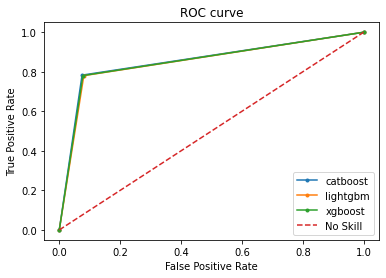

In [15]:
#plotting the ROC curve of our xgboost classifier with mean features ROC curve, 
#ROC is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
cat_model = trained_models[1]
light_model = trained_models[3]
xgb_model = trained_models[5]
y_predict_cat = cat_model.predict(x_test_mean)
y_predict_light = light_model.predict(x_test_mean)
y_predict_xgb = xgb_model.predict(x_test_mean)

x = np.linspace(0, 1, 5)
cat_fpr, cat_tpr, _ = roc_curve(y_test_mean, y_predict_cat)
light_fpr, light_tpr, _ = roc_curve(y_test_mean, y_predict_light)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_mean, y_predict_xgb)

print('The AUC of the catboost model is {:.3f}'.format(auc(cat_fpr, cat_tpr)))
print('The AUC of the lightgbm model is {:.3f}'.format(auc(light_fpr, light_tpr)))
print('The AUC of the xgboost model is {:.3f}'.format(auc(xgb_fpr, xgb_tpr)))

pyplot.plot(cat_fpr, cat_tpr, marker='.', label='catboost')
pyplot.plot(light_fpr, light_tpr, marker='.', label='lightgbm')
pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='xgboost')
pyplot.plot(x, x, linestyle='--', label='No Skill')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC curve')
pyplot.legend()
pyplot.show()

In [16]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = pyplot.subplots(figsize=figsize)
    pyplot.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

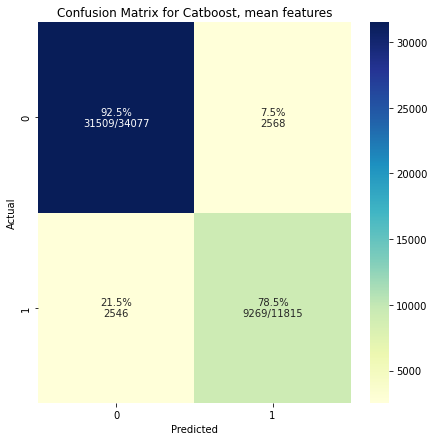

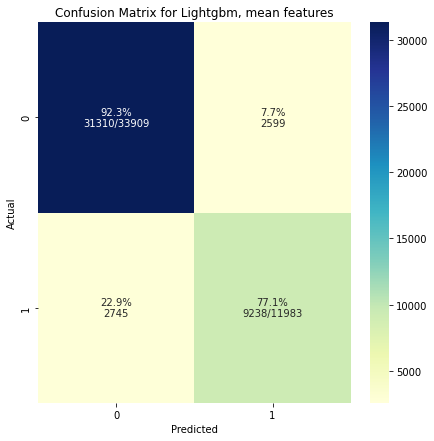

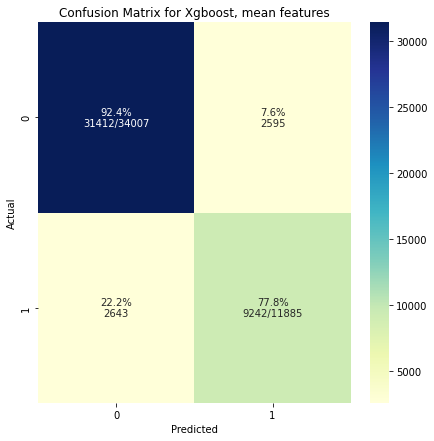

In [17]:
plot_cm(y_predict_cat, y_test_mean, 'Confusion Matrix for Catboost, mean features', figsize=(7,7))
plot_cm(y_predict_light, y_test_mean, 'Confusion Matrix for Lightgbm, mean features', figsize=(7,7))
plot_cm(y_predict_xgb, y_test_mean, 'Confusion Matrix for Xgboost, mean features', figsize=(7,7))

# 6. Explainability with SHAP

<font size="3">We will use SHAP for our Xgboost mean model, to understand better the features effect on his output.</font>

In [18]:
#Using a random sample of the dataframe for better time computation
X_sampled = x_train_mean.sample(3_000, random_state=10)

In [19]:
#explain the model's predictions using SHAP values
#(same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(trained_models[5])
shap_values = explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


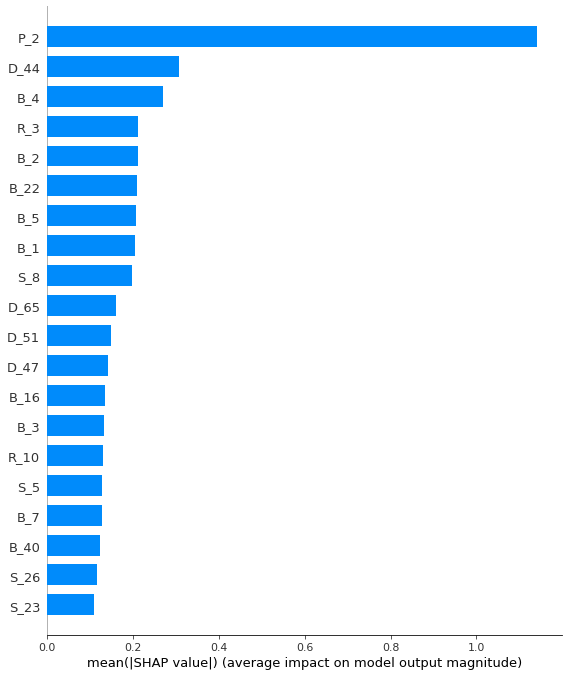

In [20]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

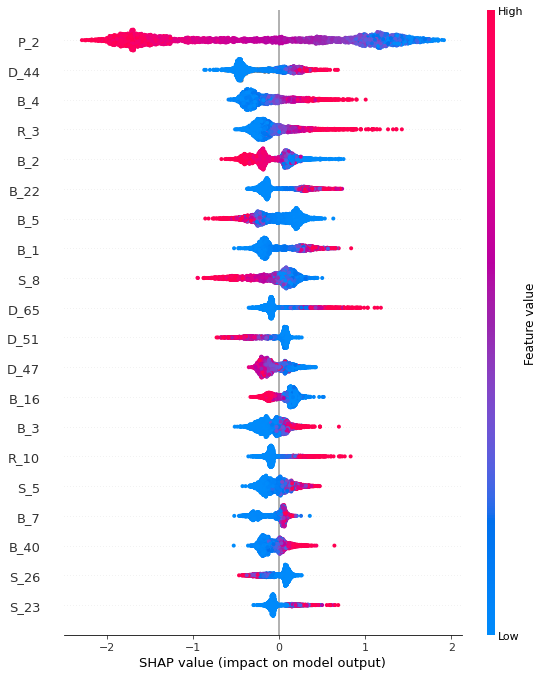

In [22]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

# Submission

In [23]:
columns_to_load = list(x_train_mean.columns)
columns_to_load = ['customer_ID'] + columns_to_load
print("The columns we use for our model: ", columns_to_load)
del(train_data)
del(train_labels)
del(x_train_median, x_test_median, y_train_median, y_test_median)
del(x_train_mean, x_test_mean, y_train_mean, y_test_mean)
del(y_predict_cat, y_predict_light, y_predict_xgb)

The columns we use for our model:  ['customer_ID', 'P_2', 'B_1', 'B_2', 'B_3', 'D_44', 'B_4', 'D_45', 'B_5', 'D_47', 'B_6', 'B_7', 'B_8', 'D_51', 'B_9', 'R_3', 'B_10', 'S_5', 'B_11', 'S_6', 'B_12', 'S_8', 'D_55', 'B_13', 'D_58', 'B_14', 'D_59', 'D_60', 'B_15', 'D_65', 'B_16', 'B_18', 'B_19', 'B_20', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'B_25', 'B_26', 'D_78', 'D_79', 'S_16', 'D_80', 'R_10', 'D_81', 'B_28', 'D_83', 'R_14', 'D_84', 'R_20', 'B_33', 'D_92', 'S_22', 'S_23', 'S_24', 'S_26', 'D_102', 'D_103', 'D_104', 'D_107', 'B_37', 'R_27', 'D_112', 'B_40', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'B_41', 'D_130', 'D_131', 'D_139', 'D_141', 'D_143', 'D_145']


In [24]:
#creates a prediction for submission, from catboost, lightgbm and xgboost models
def create_submission(data, trained_models):
    y_test_predict = trained_models[1].predict_proba(data)
    pred_final_cbm = y_test_predict[:,1]
    y_test_predict = trained_models[3].predict_proba(data)
    pred_final_lgbm = y_test_predict[:,1]
    y_test_predict = trained_models[5].predict_proba(data)
    pred_final_xgbm = y_test_predict[:,1]
    
    pred_df= pd.DataFrame({'lgbm':pred_final_lgbm,'xgbm':pred_final_xgbm,'catboost':pred_final_cbm})
    pred_df['mean'] = (pred_df['lgbm'] + pred_df['xgbm'] + pred_df['catboost'])/3
    pred_mean_values=pred_df['mean'].values
    
    # Merge the prediction and customer_ID into submission dataframe
    submission = pd.DataFrame({"customer_ID":data.index,"prediction":pred_final_cbm})
    return submission, pred_df

In [25]:
#load test data
test_data = pd.read_parquet('../input/amex-parquet/test_data.parquet',columns=columns_to_load)
print("The shape of the testdata is:", test_data.shape)
print("The number of uniqe 'customer_IDs' is: ", len(pd.unique(test_data['customer_ID'])))

The shape of the testdata is: (11363762, 94)
The number of uniqe 'customer_IDs' is:  924621


In [26]:
#get indexes for processing batches of data
indexes_for_batching_sub = get_indexes_for_batching(test_data)
print(indexes_for_batching_sub)

[1000002, 2000004, 3000003, 4000008, 5000013, 6000008, 7000009, 8000009, 9000004, 10000011, 11000010, 11363761]


In [27]:
#creating the mean features for submission
data_features = combine_customer_entries(test_data, indexes_for_batching_sub, 'mean', clean_rows=True)
print("The test features shape is: ", data_features.shape)
del(test_data)

0 (81358, 93)
1 (162617, 93)
2 (244057, 93)
3 (325447, 93)
4 (406812, 93)
5 (488256, 93)
6 (569550, 93)
7 (650898, 93)
8 (732210, 93)
9 (813535, 93)
10 (895031, 93)
11 (924621, 93)
The test features shape is:  (924621, 93)


In [28]:
submission, pred_df = create_submission(data_features, trained_models)
print("The predictions of all the three models shape: ", pred_df.shape)
print(pred_df)

The predictions of all the three models shape:  (924621, 4)
         lgbm   xgbm  catboost   mean
0       0.050  0.026     0.011  0.029
1       0.002  0.001     0.002  0.002
2       0.021  0.021     0.036  0.026
3       0.667  0.578     0.604  0.617
4       0.834  0.815     0.800  0.816
...       ...    ...       ...    ...
924616  0.023  0.027     0.015  0.022
924617  0.661  0.602     0.780  0.681
924618  0.672  0.696     0.557  0.642
924619  0.663  0.433     0.518  0.538
924620  0.164  0.059     0.160  0.128

[924621 rows x 4 columns]


In [29]:
print("The submission shape: ", submission.shape)
print(submission)

The submission shape:  (924621, 2)
                                              customer_ID  prediction
0       00000469ba478561f23a92a868bd366de6f6527a684c9a...       0.011
1       00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...       0.002
2       0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...       0.036
3       00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...       0.604
4       00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...       0.800
...                                                   ...         ...
924616  ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...       0.015
924617  ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...       0.780
924618  ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...       0.557
924619  ffffddef1fc3643ea179c93245b68dca0f36941cd83977...       0.518
924620  fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...       0.160

[924621 rows x 2 columns]
